In [28]:
print("Hello World")

Hello World


In [29]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [30]:
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [31]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [32]:
# SOLUTION: Direct approach using HumanMessage
print("=== DIRECT SUMMARIZATION APPROACH ===")
from langchain_core.messages import HumanMessage

try:
    # Extract text content from documents
    text_content = "\n\n".join([doc.page_content for doc in docs])
    
    # Limit content to avoid token limits (first 8000 characters)
    limited_content = text_content[:8000]
    
    # Create direct human message with summarization request
    summary_message = HumanMessage(
        content=f"""Please write a concise summary of the following content:

{limited_content}

Please provide a clear, well-structured summary that captures the main points and key concepts."""
    )
    
    # Invoke LLM directly
    response = llm.invoke([summary_message])
    
    print("✅ DIRECT SUMMARIZATION SUCCESS!")
    print("="*50)
    print("SUMMARY:")
    print("="*50)
    print(response.content)
    print("="*50)
    
except Exception as e:
    print("❌ Direct summarization failed:")
    print(f"Error: {str(e)}")
    print(f"Error type: {type(e)}")


=== DIRECT SUMMARIZATION APPROACH ===
✅ DIRECT SUMMARIZATION SUCCESS!
SUMMARY:
This article explores the concept of LLM-powered autonomous agents, positioning LLMs as the "brain" of the agent. These agents consist of three core components: Planning, Memory, and Tool Use.

**Planning** involves breaking down complex tasks into subgoals (Task Decomposition) using techniques like Chain of Thought (CoT) and Tree of Thoughts, or leveraging external planners. It also encompasses Self-Reflection, allowing the agent to learn from past actions and improve future performance through approaches like ReAct, Reflexion, and Chain of Hindsight (CoH).

**Memory** is divided into short-term (in-context learning) and long-term, the latter often employing external vector stores for persistent information retrieval.

**Tool Use** enables the agent to access external APIs for information unavailable within the LLM's parameters, such as current events or proprietary data.

The article briefly mentions case 

# Map Reduce

In [34]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_prompt

ChatPromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template='Write a concise summary of the following:\\n\\n{context}'), additional_kwargs={})])

In [36]:
from langchain import hub
map_prompt = hub.pull("rlm/map-prompt")
reduce_prompt = hub.pull("rlm/reduce-prompt")

reduce_prompt

ChatPromptTemplate(input_variables=['doc_summaries'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'reduce-prompt', 'lc_hub_commit_hash': 'a3d558b35e478278c448c2988cd2ed1422cede59d59c63cf203b733d4ddf73f0'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['doc_summaries'], input_types={}, partial_variables={}, template='The following is set of summaries:\n{doc_summaries}\nTake these and distill it into a final, consolidated summary of the main themes. \nHelpful Answer:'), additional_kwargs={})])

In [37]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=0
)

split_docs = text_splitter.split_documents(docs)

print(f"Split docs: {len(split_docs)}")


Created a chunk of size 1003, which is longer than the specified 1000


Split docs: 13


In [41]:

from langchain.schema import Document
from typing import List, Literal
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.constants import Send
from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)

from langgraph.graph import StateGraph, START, END

token_max = 1000

def length_function(documents: List[Document]) -> int:
    """ Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str

class SummaryState(TypedDict):
    content: str

async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}

def map_summaries(state: OverallState):
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }

async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content

async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}

def should_collapse(state: OverallState) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


graph = StateGraph(OverallState)

graph.add_node("generate_summary", generate_summary)
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

graph.add_conditional_edges(
    START,
    map_summaries,
    ["generate_summary"],
)

graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()





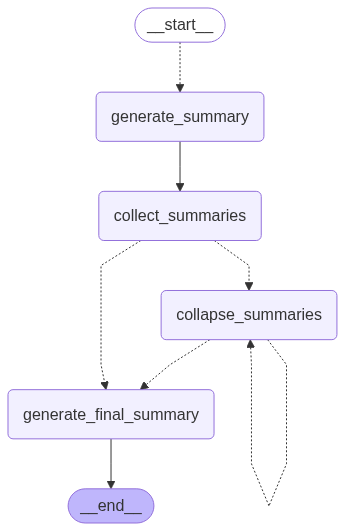

In [42]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [43]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']


Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 16
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 14
}
]